# info

##### モデリング
1. Grid Searchでハイパーパラメーターを求めている
1. 特徴量エンジニアリングを施したデータとそうでないデータなど、複数のデータで複数のモデルを生成している
1. モデルの出力値を適切に加工している
    - 対数変換した目的変数に対する出力をしていれば、逆関数で再現
    - 分類のprobaであれば、分析結果をもとにした閾値を設けて0,1に変換

##### 検証
1. cross validationで未知データに対する精度に近い精度を求めている
1. 線形モデルや決定木を使用し、モデルがどのような特徴を重要として出力しているか確認している
    - ※ロジスティック回帰かSVCか決定木
    - ※係数や分岐を確認する

# init

In [1]:
import os, copy
import numpy as np
import pandas as pd
import uuid
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.externals import joblib

# load

In [2]:
path_doc = "../doc/"

In [3]:
path_data = "../data/"
path_clns = path_data + "clns/"

In [4]:
_dic_data = dict()
for d in os.listdir(path_clns):
    fn = d.split(".")[0]
    _dic_data[fn] = pd.read_csv(path_clns+d, index_col=0)

In [6]:
_dic_data.keys()

dict_keys(['num_logz', 'num_z', 'onehot_bools', 'onehot_cats', 'onehot_familysize', 'onehot_ischild', 'onehot_parch_sibsp', 'tgt_bools', 'tgt_cats', 'tgt_familysize', 'tgt_parch_sibsp', 'y'])

In [7]:
def get_mart(log=False, oh=False, tgt=False, fam=False, ps=False):
    dic_data = copy.deepcopy(_dic_data)
    yname = "survived"
    y = dic_data["y"]
    test_id = y[y[yname].isna()].index
    
    nums = dic_data["num_z"]
    cats = list()

    onehot = [v for k, v in dic_data.items() if ("onehot" in k) and not ("family" in k or "parch_sibsp" in k)]
    onehot_fam = [v for k, v in dic_data.items() if ("onehot" in k) and ("family" in k)]
    onehot_ps = [v for k, v in dic_data.items() if ("onehot" in k) and ("parch_sibsp" in k)]
    
    tgtenc = [v for k, v in dic_data.items() if ("tgt" in k) and not ("family" in k or "parch_sibsp" in k)]
    tgt_fam = [v for k, v in dic_data.items() if ("tgt" in k) and ("family" in k)]
    tgt_ps = [v for k, v in dic_data.items() if ("tgt" in k) and ("parch_sibsp" in k)]

    if log:
        nums = dic_data["num_logz"]
    if oh:
        cats += onehot
    if tgt:
        cats += tgtenc
    if fam:
        if oh:
            cats += onehot_fam
        if tgt:
            cats += onehot_ps
    if ps:
        if oh:
            cats += tgt_fam
        if tgt:
            cats += tgt_ps
            
    mart = pd.concat([y, nums, *cats], axis=1)
    train, test = mart[~mart.index.isin(test_id)], mart[mart.index.isin(test_id)]
    train_X, train_y, test_X = train.drop(yname, 1), train[yname], test.drop(yname, 1)
    return train_X, train_y, test_X

# modeling

## LR

In [22]:
def objective(trial):
    flder = "lr_v0/"
    p = "../model/tuning/"+flder
    if not os.path.exists(p):
        os.mkdir(p)
        
    trial_uuid = str(uuid.uuid4())
    trial.set_user_attr("uuid", trial_uuid)

    log = trial.suggest_int("use_log", 0, 1)
    oh =  trial.suggest_int("use_oh", 0, 1)
    tgt = trial.suggest_int("use_tgt", 0, 1)
    fam = trial.suggest_int("use_fam", 0, 1)
    ps = trial.suggest_int("use_ps", 0, 1)
    
    param_grid = {
        'C' : trial.suggest_int("C", 1, 20),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        "random_state": 0
    }
    train_X, train_y, test_X = get_mart(log, oh, tgt, fam, ps)
    
    model = LogisticRegression(**param_grid)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_validate(model, X=train_X, y=train_y, cv=kf, scoring="roc_auc")
    auc = scores['test_score'].mean()
    
    # レポーティング
    with open(p+"00.report.csv", mode="a", encoding="utf8") as f:
        r = [trial_uuid, log, oh, tgt, fam, ps, *param_grid.values(), auc]
        r = [str(v) for v in r]
        print(",".join(r), file=f)
    
    model.fit(train_X, train_y)
    joblib.dump(model, p+"%s.pkl"%trial_uuid)
    
    return auc

In [23]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=256)

[I 2020-03-30 00:18:34,188] Finished trial#0 resulted in value: 0.7104848978957994. Current best value is 0.7104848978957994 with parameters: {'use_log': 1, 'use_oh': 0, 'use_tgt': 0, 'use_fam': 1, 'use_ps': 1, 'C': 18, 'penalty': 'l1'}.
[I 2020-03-30 00:18:34,375] Finished trial#1 resulted in value: 0.8613097179239737. Current best value is 0.8613097179239737 with parameters: {'use_log': 0, 'use_oh': 0, 'use_tgt': 1, 'use_fam': 1, 'use_ps': 1, 'C': 5, 'penalty': 'l1'}.
[I 2020-03-30 00:18:34,469] Finished trial#2 resulted in value: 0.8576350204652092. Current best value is 0.8613097179239737 with parameters: {'use_log': 0, 'use_oh': 0, 'use_tgt': 1, 'use_fam': 1, 'use_ps': 1, 'C': 5, 'penalty': 'l1'}.
[I 2020-03-30 00:18:34,599] Finished trial#3 resulted in value: 0.8583932869677104. Current best value is 0.8613097179239737 with parameters: {'use_log': 0, 'use_oh': 0, 'use_tgt': 1, 'use_fam': 1, 'use_ps': 1, 'C': 5, 'penalty': 'l1'}.
[I 2020-03-30 00:18:34,687] Finished trial#4 result

[I 2020-03-30 00:18:53,009] Finished trial#68 resulted in value: 0.8678329617428149. Current best value is 0.8693032955087462 with parameters: {'use_log': 1, 'use_oh': 0, 'use_tgt': 1, 'use_fam': 1, 'use_ps': 1, 'C': 4, 'penalty': 'l2'}.
[I 2020-03-30 00:18:53,334] Finished trial#69 resulted in value: 0.8650341641431787. Current best value is 0.8693032955087462 with parameters: {'use_log': 1, 'use_oh': 0, 'use_tgt': 1, 'use_fam': 1, 'use_ps': 1, 'C': 4, 'penalty': 'l2'}.
[I 2020-03-30 00:18:53,636] Finished trial#70 resulted in value: 0.8693032955087462. Current best value is 0.8693032955087462 with parameters: {'use_log': 1, 'use_oh': 0, 'use_tgt': 1, 'use_fam': 1, 'use_ps': 1, 'C': 4, 'penalty': 'l2'}.
[I 2020-03-30 00:18:53,907] Finished trial#71 resulted in value: 0.8693032955087462. Current best value is 0.8693032955087462 with parameters: {'use_log': 1, 'use_oh': 0, 'use_tgt': 1, 'use_fam': 1, 'use_ps': 1, 'C': 4, 'penalty': 'l2'}.
[I 2020-03-30 00:18:54,227] Finished trial#72 re

[I 2020-03-30 00:19:18,462] Finished trial#136 resulted in value: 0.858316694951915. Current best value is 0.8693032955087462 with parameters: {'use_log': 1, 'use_oh': 0, 'use_tgt': 1, 'use_fam': 1, 'use_ps': 1, 'C': 4, 'penalty': 'l2'}.
[I 2020-03-30 00:19:18,768] Finished trial#137 resulted in value: 0.8530435481902987. Current best value is 0.8693032955087462 with parameters: {'use_log': 1, 'use_oh': 0, 'use_tgt': 1, 'use_fam': 1, 'use_ps': 1, 'C': 4, 'penalty': 'l2'}.
[I 2020-03-30 00:19:19,169] Finished trial#138 resulted in value: 0.863594001308886. Current best value is 0.8693032955087462 with parameters: {'use_log': 1, 'use_oh': 0, 'use_tgt': 1, 'use_fam': 1, 'use_ps': 1, 'C': 4, 'penalty': 'l2'}.
[I 2020-03-30 00:19:19,538] Finished trial#139 resulted in value: 0.7105877785542356. Current best value is 0.8693032955087462 with parameters: {'use_log': 1, 'use_oh': 0, 'use_tgt': 1, 'use_fam': 1, 'use_ps': 1, 'C': 4, 'penalty': 'l2'}.
[I 2020-03-30 00:19:19,877] Finished trial#140

[I 2020-03-30 00:19:47,400] Finished trial#204 resulted in value: 0.8623996982906836. Current best value is 0.8693032955087462 with parameters: {'use_log': 1, 'use_oh': 0, 'use_tgt': 1, 'use_fam': 1, 'use_ps': 1, 'C': 4, 'penalty': 'l2'}.
[I 2020-03-30 00:19:47,872] Finished trial#205 resulted in value: 0.8587058112320166. Current best value is 0.8693032955087462 with parameters: {'use_log': 1, 'use_oh': 0, 'use_tgt': 1, 'use_fam': 1, 'use_ps': 1, 'C': 4, 'penalty': 'l2'}.
[I 2020-03-30 00:19:48,284] Finished trial#206 resulted in value: 0.7104848978957994. Current best value is 0.8693032955087462 with parameters: {'use_log': 1, 'use_oh': 0, 'use_tgt': 1, 'use_fam': 1, 'use_ps': 1, 'C': 4, 'penalty': 'l2'}.
[I 2020-03-30 00:19:48,755] Finished trial#207 resulted in value: 0.8525739021441326. Current best value is 0.8693032955087462 with parameters: {'use_log': 1, 'use_oh': 0, 'use_tgt': 1, 'use_fam': 1, 'use_ps': 1, 'C': 4, 'penalty': 'l2'}.
[I 2020-03-30 00:19:49,254] Finished trial#2

In [24]:
print(study.best_params)
print(study.best_value)

{'use_log': 1, 'use_oh': 0, 'use_tgt': 1, 'use_fam': 1, 'use_ps': 1, 'C': 4, 'penalty': 'l2'}
0.8693032955087462


In [29]:
def objective(trial):
    param_grid = {
        'C' : trial.suggest_uniform("C", 3, 5),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        "random_state": 0
    }
    train_X, train_y, test_X = get_mart(1,0,1,1,1)
    
    model = LogisticRegression(**param_grid)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_validate(model, X=train_X, y=train_y, cv=kf, scoring="roc_auc")
    auc = scores['test_score'].mean()
    
    return auc

In [30]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2020-03-31 20:33:58,902] Finished trial#0 resulted in value: 0.8691984737058112. Current best value is 0.8691984737058112 with parameters: {'C': 3.9666535073022597, 'penalty': 'l2'}.
[I 2020-03-31 20:33:59,082] Finished trial#1 resulted in value: 0.860160948609586. Current best value is 0.8691984737058112 with parameters: {'C': 3.9666535073022597, 'penalty': 'l2'}.
[I 2020-03-31 20:33:59,251] Finished trial#2 resulted in value: 0.8631642319168524. Current best value is 0.8691984737058112 with parameters: {'C': 3.9666535073022597, 'penalty': 'l2'}.
[I 2020-03-31 20:33:59,416] Finished trial#3 resulted in value: 0.8663790999744878. Current best value is 0.8691984737058112 with parameters: {'C': 3.9666535073022597, 'penalty': 'l2'}.
[I 2020-03-31 20:33:59,588] Finished trial#4 resulted in value: 0.8613935753663217. Current best value is 0.8691984737058112 with parameters: {'C': 3.9666535073022597, 'penalty': 'l2'}.
[I 2020-03-31 20:33:59,753] Finished trial#5 resulted in value: 0.86763

[I 2020-03-31 20:34:13,649] Finished trial#87 resulted in value: 0.86855756325358. Current best value is 0.8693032955087462 with parameters: {'C': 3.984355392365096, 'penalty': 'l2'}.
[I 2020-03-31 20:34:13,780] Finished trial#88 resulted in value: 0.8693032955087462. Current best value is 0.8693032955087462 with parameters: {'C': 3.984355392365096, 'penalty': 'l2'}.
[I 2020-03-31 20:34:13,994] Finished trial#89 resulted in value: 0.86876720685945. Current best value is 0.8693032955087462 with parameters: {'C': 3.984355392365096, 'penalty': 'l2'}.
[I 2020-03-31 20:34:14,207] Finished trial#90 resulted in value: 0.8624322540569921. Current best value is 0.8693032955087462 with parameters: {'C': 3.984355392365096, 'penalty': 'l2'}.
[I 2020-03-31 20:34:14,364] Finished trial#91 resulted in value: 0.8686604439120164. Current best value is 0.8693032955087462 with parameters: {'C': 3.984355392365096, 'penalty': 'l2'}.
[I 2020-03-31 20:34:14,523] Finished trial#92 resulted in value: 0.8689779

In [31]:
print(study.best_params)
print(study.best_value)

{'C': 3.984355392365096, 'penalty': 'l2'}
0.8693032955087462


In [36]:
setting = "10111"


In [37]:
setting = "10111"
params = [int(f) for f in setting]
train_X, train_y, test_X = get_mart(*params)
model = LogisticRegression(**study.best_params)
model.fit(train_X, train_y)
joblib.dump(model, "../model/lr_%s.pkl"%setting)

submit = test_X.copy()[[]]
submit["pred"] = model.predict_proba(test_X)[:,1]
submit.to_csv("../data/submit/"+"lr_%s.tsv"%setting, sep="\t", header=None)
# res: auc = 0.84586

In [38]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-pastel")

<BarContainer object of 17 artists>

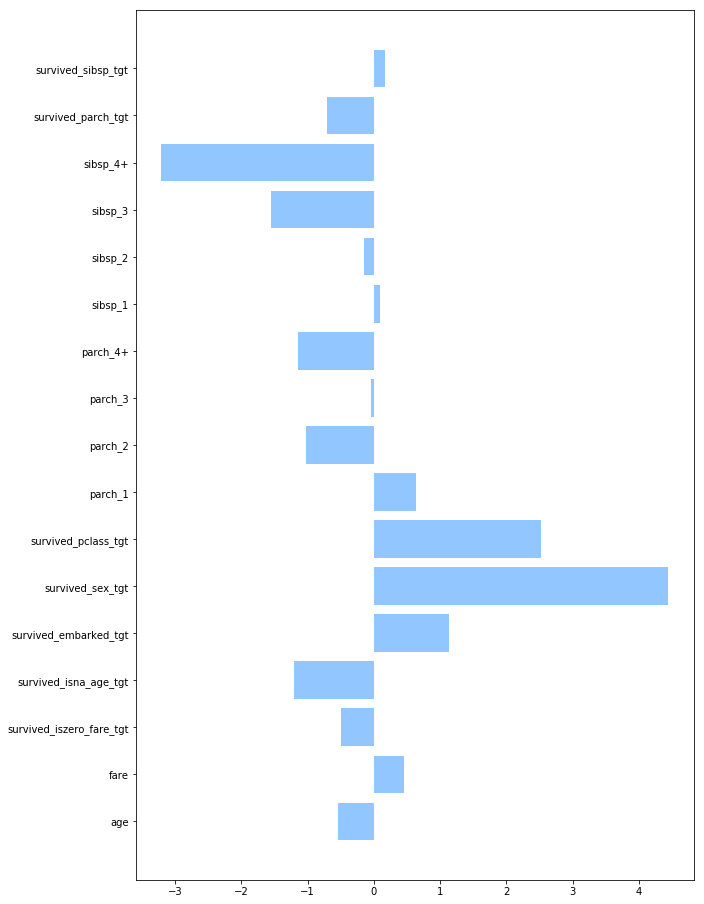

In [39]:
plt.figure(figsize=(10,16))
plt.barh(y=train_X.columns, width=model.coef_[0])

##### モデリング
- チェックポイント1: Grid Searchでハイパーパラメーターを求めている
- チェックポイント2: 特徴量エンジニアリングを施したデータとそうでないデータなど、複数のデータで複数のモデルを生成している

##### 検証
- チェックポイント1: cross validationで未知データに対する精度に近い精度を求めている
- チェックポイント2: 線形モデルや決定木を使用し、モデルがどのような特徴を重要として出力しているか確認している
    - 性別・客室の等級・家族構成(sibsp)の影響が比較的に大きい。